In [4]:
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
import scipy.io
import scipy.optimize as op
import pandas as pd
import emcee as mc
import corner

import io as IO
import pickle
import os
import os.path
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from googleapiclient.http import MediaFileUpload
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2 import service_account

plt.rc('font', size=22) #set default font size to 22 (from 10)

ModuleNotFoundError: No module named 'googleapiclient'

## Janine Birnbaum 

Created June 28, 2019

Last update July 31, 2019

Read flow data from video files and still images and compare with model.

In [5]:
# Shortcut functions for trigonometric functions in degrees

def sind(theta):
    """Calculate sine of theta in degrees.
    
    :Input:
     - *theta* (array_like) - Angle in degrees.
     
     :Output:
     - (array_like) - Sine value.
    
    """
    
    return np.sin(np.deg2rad(theta))

def cosd(theta):
    """Calculate cosine of theta in degrees.
    
    :Input:
     - *theta* (array_like) - Angle in degrees.
     
     :Output:
     - (array_like) - Cosine value.
    
    """
    
    return np.cos(np.deg2rad(theta))

def tand(theta):
    """Calculate cosine of theta in degrees.
    
    :Input:
     - *theta* (array_like) - Angle in degrees.
     
     :Output:
     - (array_like) - Cosine value.
    
    """
    
    return np.tan(np.deg2rad(theta))

## Flow of a Herschel-Bulkley fluid on an inclined plane following derivation from Liu & Mei (1989), Balmforth et al. (2007):

$ \frac{\partial h}{\partial t} = -\left( \frac{\rho g}{K} \right)^{1/n} \frac{\partial}{\partial x} \left[ \frac{n \left| \sin{\theta} - \cos{\theta} \frac{\partial h}{\partial x} \right|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right] \left( \sin{\theta} -  \cos{\theta} \frac{\partial h}{\partial x} \right) \right] $

$ Y = h - \frac{\tau_y}{\rho g |\sin{\theta} -\cos{\theta} \frac{\partial h}{\partial x}|} $

For full derivation see included PDF "Viscoplastic Flow Derivation".

In [6]:
def damBreak(x, h0, theta, rho, K, tauy, n, g, ts, i):
    
    """Solve flow for a Herschel-Bulkley fluid with 2-step Runge-Kutta 
    in time, centered in space for on an inclined surface.
    
    :Input:
     - *x*     (ndarray(m+2))      - Evaluation points in x [m].
     - *h0*    (ndarray(m+2))      - Initial height at evaluation points in x [m].
     - *theta* (float)             - Slope [deg].
     - *rho*   (float)             - Fluid density [kg/m^3].
     - *K*     (float)             - Fluid consistency [Pa s].     
     - *tauy*  (float)             - Yield stress [Pa].
     - *n*     (float)             - Rheology power law exponent.
     - *g*     (float)             - Gravitational constant [m/s^2].
     - *ts*    (float)             - Final time for simulation [sec].
     - *i*     (int)               - Number of points for discretization in t.
     

    :Output:
     - (ndarray(m+2, i+2)) - Solution of ODE.
     - (ndarray(i+2)) - Evaluation times.
    """

    # Discretize domain 
    dx = x[1:] - x[:-1]
    dt = ts/(i+1)
    t = np.linspace(0, ts, i+2)

    # Initialize solution
    h = np.zeros((i+2,x.size))    
    h[0,:] = h0
    
    # Solve
    for k in np.arange(i+1):
        
        for j, s in enumerate([0.5, 1]):
            
            hr = (h[k+j,2:] + h[k+j,1:-1])/2
            hl = (h[k+j,1:-1] + h[k+j,:-2])/2
            hxr = sind(theta) - cosd(theta)*(h[k+j,2:] - h[k+j,1:-1])/dx[1:]
            hxl = sind(theta) - cosd(theta)*(h[k+j,1:-1] - h[k+j,:-2])/dx[:-1]
            Yr  = hr - tauy/(rho*g*np.abs(hxr))
            Yl  = hl - tauy/(rho*g*np.abs(hxl))
        
            Yr[Yr<0] = 0
            Yl[Yl<0] = 0
        
            Qr = n*((np.abs(hxr))**(1/n-1)*(Yr)**(1+1/n))/((n+1)*(2*n+1))*((1+2*n)*hr - n*Yr)*hxr
            Ql = n*((np.abs(hxl))**(1/n-1)*(Yl)**(1+1/n))/((n+1)*(2*n+1))*((1+2*n)*hl - n*Yl)*hxl
        
            Qr[hxr==0] = 0
            Ql[hxl==0] = 0
    
            h[k+1,1:-1] = h[k,1:-1] - s*dt/dx[:-1]*(rho*g/K)**(1/n)*(Qr - Ql)
            
            # Boundary conditions
            h[k+1,0] = h[k+1,1]
    
    return h, t

## Comparison to experimental data

Import video of experimental data and find the flow front through time:

In [3]:
# import from google drive

SCOPES = ['https://www.googleapis.com/auth/drive']

"""Shows basic usage of the Drive v3 API.
Prints the names and ids of the first 10 files the user has access to.
"""
creds = None
# The file token.pickle stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token_.pickle'):
    with open('token_.pickle', 'rb') as token:
        creds = pickle.load(token)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'client_secret.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('token_.pickle', 'wb') as token:
        pickle.dump(creds, token)
        
service = build('drive', 'v3', credentials=creds)

# Call the Drive v3 API
results = service.files().list(q = "name contains 'MVI_0700_edit'", # change just this line to the video filename
    pageSize=5, fields="nextPageToken, files(id, name)").execute()
items = results.get('files', [])

if not items:
    print('No files found.')

fileid = items[0]['id']
filename =  items[0]['name']
filepath = os.getcwd()
request = service.files().get_media(fileId=fileid)
fh = IO.BytesIO()
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))

print('Saving local copy')
with IO.open(filepath + '/' + filename, 'wb') as f:
    fh.seek(0)
    f.write(fh.read())
print('Done! Loaded ' + filename)

NameError: name 'os' is not defined

In [12]:
def Visc(T): 
    """Calculate viscosity of 77% sugar corn syrup at specified Temperature based on 
    best-fit curve calibrated between 23.5 - 46 deg C.
    
    :Input:
     - *T* (array_like)      - Evaluation temperatures in [deg C].
     
    :Output:
     - (array_like)          - Viscosity at temperatures T in [Pa s].

    """
    return 15603*T**(-2.44)

In [13]:
# Change these parameters

startFrame = 0
endFrame = 750

# RGB channel and threshold for front picking
thresh = 150
channel = 2 #0 = Red, 1 = Green, 2 = Blue

# manually set starting location, line for analysis
# black in next figure
x0 = 468 # pixels
yline = 1200

# crop image
top = 900
bottom = 1500
left = 0
right = 1000

title_str = 'Experiment Name'
L = 0.2 # reservoir length in m
H = 0.05 # fluid height in reservoir in m
rho = 1400 # fluid density in kg/m^3
theta = 0 # slope in degrees
T = 25 # temperature in deg C
K_fluid = Visc(T) # syrup viscosity in Pas

In [1]:
y2 = bottom - top - 1
x2 = right - left - 1

# read first frame from video
cap = cv2.VideoCapture(filename)
fps = cap.get(cv2.CAP_PROP_FPS)

ret, frame = cap.read()
if ret:
    pic = np.flip(frame,2)
    #pic = np.transpose(pic,axes=(1,0,2)) #turn on for flow from top to bottom
cap.release()

# plot cropped image, profile for analysis
# x0 and yline in black
# threshold and profile along yline in red
fig,ax = plt.subplots(figsize=(20,10))
ax.imshow(pic[top:bottom,left:right,:])
ax.plot([x0, x0], [0, y2], 'k')
ax.plot([1, x2], [yline-top, yline-top], 'k')
ax2 = ax.twinx() 
ax2.plot(pic[yline,left:right,channel], 'r')
ax2.plot([1, x2], [thresh, thresh], 'r')
ax2.invert_yaxis()
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax2.set_ylabel('Brightness')
ax.set_title(title_str);

NameError: name 'bottom' is not defined

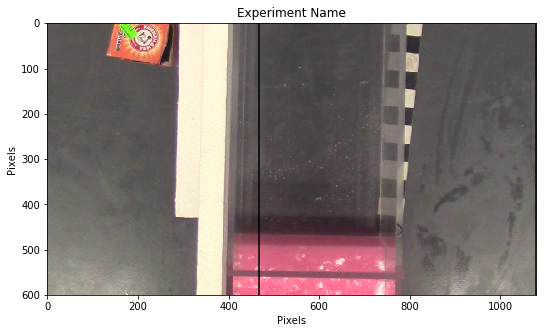

In [15]:
currentFrame = 0

y2 = bottom - top - 1

# read video from start to end frame
cap = cv2.VideoCapture(filename)
fps = cap.get(cv2.CAP_PROP_FPS)
pos = np.zeros(endFrame-startFrame)

while(currentFrame<endFrame):
    ret, frame = cap.read()
    if currentFrame >= startFrame:
        if ret:
            pic = np.flip(frame,2)
            #pic = np.transpose(pic,axes=(1,0,2)) #turn on for flow from top to bottom
            pos[currentFrame - startFrame] = np.max(np.where(pic[yline,left:right,channel]<thresh))
    
    currentFrame += 1
    
cap.release()

# plot final frame
fig,ax = plt.subplots(figsize=(15,5))
ax.imshow(pic[top:bottom,left:right,:])
ax.plot([x0, x0], [0, y2], 'k')
ax.plot([pos[-1], pos[-1]], [0, y2], 'k')
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax.set_title(title_str);

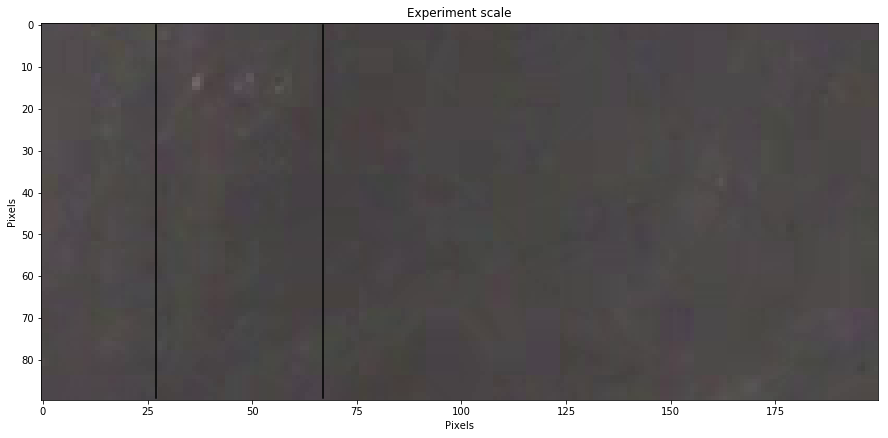

In [16]:
# Calculate image scale
# Crop image
top2 = 860
bottom2 = 950
left2 = 500
right2 = 700

# Plot
fig,ax = plt.subplots(figsize=(15,20))
ax.imshow(pic[top2:bottom2,left2:right2,:])

# Set to align with one 2cm segment on scale
lft = 27
rgt = 67

# Plot
ax.plot([lft, lft], [0, bottom2-top2-1], 'k')
ax.plot([rgt, rgt], [0, bottom2-top2-1], 'k')

# Determine scaling factors
W = 0.02 # m
k = W/(rgt-lft) # m/pixel
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax.set_title('Experiment scale');

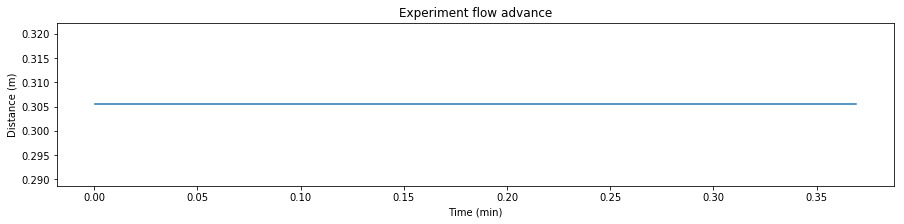

In [17]:
# scale time and front position
pos_scaled = (pos-x0)*k
pos_scaled[pos_scaled<0] = 0
t_scaled = np.arange((pos_scaled).size)/fps

t0 = 2.85 # Time of dam release [sec]

pos_scaled = pos_scaled[t_scaled>t0]
t_scaled = t_scaled[t_scaled>t0]-t0

# plot scaled front advance
fig,ax = plt.subplots(figsize=(15,3))
ax.plot(t_scaled/60, pos_scaled)
ax.set_xlabel('Time (min)')
ax.set_ylabel('Distance (m)')
ax.set_title('Experiment flow advance');

In [19]:
# Save data to file

df = pd.DataFrame({'X_pos':pos_scaled, 'Time':t_scaled})
meta = pd.DataFrame({'H':H, 'L':L, 'K_fluid':K_fluid, 'Rho':rho, 'Slope':theta, 'Title':title_str, 'Temp':T}, index=[0])

df.to_hdf(title_str + '.h5', key='df', mode='w')
meta.to_hdf(title_str + '.h5', key='meta', mode='a')

file_metadata = {'name': title_str + '.h5', 'parents': ['1zM6oSJugXEWYybwzwO0YVvfAShTHpKbp']}
media = MediaFileUpload(title_str + '.h5')
file = service.files().create(body=file_metadata,
                                    media_body=media).execute()

In [ ]:
# Setup model for MCMC

def lnlike(mu, x, y, yerr):
    K, tauy, n = mu
    h, t = damBreak(x_grid, h0, 0, 1540, K, tauy, n, 9.81, t_scaled[-1], 25*t_scaled.shape[0])
    X = np.zeros_like(t_scaled)

    threshold = 0.0001
    for j in np.arange(t_scaled.shape[0]):
        X[j] = x_grid[np.max(np.nonzero(h[j*25,:]>threshold)) + 1] # find node with h>threshold

    model = X
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [ ]:
# Initial guesses for MCMC
K_init = 20
K_min = 8
K_max = 25

tauy_init = 0.1
tauy_min = 0
tauy_max = 0.5

n_init = 1
n_min = 0.8
n_max = 3

init_pos = [K_init, tauy_init, n_init]

# load data to MCMC
x = t_scaled
y = pos_scaled + L

# Define model resolution for MCMC
x_grid = np.linspace(0,0.75,22)
dx = x[1] - x[0]
yerr = 2*dx
h0 = np.zeros_like(x_grid)
h0[x_grid<0.2] = H

In [ ]:
# Uniform prior distribution
def lnprior(mu):
    K, tauy, n = mu
    if K_min < K < K_max and tauy_min < tauy < tauy_max and n_min < n < n_max:
        return 0.0
    return -np.inf

def lnprob(mu, x, y, yerr):
    lp = lnprior(mu)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(mu, x, y, yerr)

In [ ]:
# Create walkers
ndim, nwalkers = 3, 20
mu_pos = [init_pos + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [ ]:
# Run MCMC
sampler = mc.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(mu_pos, 100);

In [ ]:
# Inspect MCMC results
samples = sampler.chain[:, :, :].reshape((-1, ndim))

s = 0 # ignore initial samples
K_fit = samples[s:,0]; tauy_fit = samples[s:,1]; n_fit = samples[s:,2]

# Find mode of each posterior distribution
N, bin_edges = np.histogram(K_fit, bins=20)
K_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(tauy_fit, bins=20)
tauy_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(n_fit, bins=20)
n_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 

# plot
fig = corner.corner(samples, labels=["K", "tauy", "n"],
                   truths=[K_post, tauy_post, n_post])

In [ ]:
# inspect runs
fig,ax = plt.subplots(nrows=3, figsize=(15,15))
ax[0].plot(samples[:,0])
ax[0].set_xlabel('K')
ax[1].plot(samples[:,1])
ax[1].set_xlabel('tauy')
ax[2].plot(samples[:,2])
ax[2].plot('n');

In [ ]:
# Plot most probable model with data

h, t = damBreak(x_grid, h0, 0, 1540, K_post, tauy_post, n_post, 9.81, np.max(t_scaled), 25*t_scaled.shape[0])
X = np.zeros_like(t_scaled)
t_match = np.zeros_like(t_scaled)

threshold = 0.0001
for j in np.arange(t_scaled.shape[0]):
    X[j] = x_grid[np.max(np.nonzero(h[j*25,:]>threshold)) + 1] # find node with h>threshold
    t_match[j] = t[j*25]

# Plot front advance
fig,ax = plt.subplots(figsize=(20,10))

ax.plot(t_match,X,'r-',label='model');
ax.plot(t_scaled,pos_scaled+L,label='experiment')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (m)')
ax.set_title('Model fit to experiment')
ax.legend();

In [ ]:
# Save posterior distribution

meta['K_post'] = K_post
meta['tauy_post'] = tauy_post
meta['n_post'] = n_post

meta.to_hdf(title_str + '.h5', key='meta', mode='a')

samples = pd.DataFrame({'K':K_fit, 'tauy':tauy_fit, 'n':n_fit})
samples.to_hdf(title_str + '.h5', key='s', mode='a')

file_metadata = {'name': title_str + '.h5', 'parents': ['1zM6oSJugXEWYybwzwO0YVvfAShTHpKbp']}
media = MediaFileUpload(title_str + '.h5')
file = service.files().create(body=file_metadata,
                                    media_body=media).execute()

In [33]:
# remove local files after upload
media = None

os.remove(filename)
os.remove(title_str + '.h5')